In [1]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from langdetect import detect, DetectorFactory
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm
from wordcloud import WordCloud
import nest_asyncio
import praw

nest_asyncio.apply()

nltk.download("vader_lexicon")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [42]:
reddit = praw.Reddit(
    client_id="",
    client_secret="",
    user_agent="",
)

In [4]:
print(reddit.read_only)

True


In [5]:
reddit

In [6]:
subreddit = reddit.subreddit("movies")

reviews = []
for submission in subreddit.new(limit=100):  # You can adjust the limit
    # if "review" in submission.title.lower():
    #     reviews.append(submission.selftext)  # selftext is the post body
    # keywords = ["review", "thoughts", "opinion", "watched"]
    # if any(kw in submission.title.lower() for kw in keywords):
    #     reviews.append(submission.selftext)
    if submission.selftext:  # Only collect non-empty posts
        reviews.append(submission.selftext)

print(f"Collected {len(reviews)} reviews.")

Collected 72 reviews.


In [7]:
# reviews[:5]

In [7]:
subreddit = reddit.subreddit("movies")
reviews = []

inception_keywords = ["inception", "INCEPTION", "inception movie"]

for submission in subreddit.new(limit=200):  # You can increase the limit for better coverage
    title = submission.title.lower()
    body = submission.selftext.lower()
    
    if any(kw in title or kw in body for kw in inception_keywords):
        if submission.selftext.strip():  # Make sure it's not empty
            reviews.append(submission.selftext.strip())

print(f"Collected {len(reviews)} Inception-related reviews/posts.")

Collected 2 Inception-related reviews/posts.


In [8]:
subreddit = reddit.subreddit("Inception")

In [9]:
for submission in subreddit.new(limit=500):  # Adjust the limit as needed
    if submission.selftext:
        reviews.append(submission.selftext)

print('Collected: ', len(reviews), 'Inception-related reviews/posts.')

Collected:  327 Inception-related reviews/posts.


In [10]:
DetectorFactory.seed = 0  # To make detection more consistent

reviews = []

for submission in subreddit.new(limit=500):
    if submission.selftext:
        try:
            if detect(submission.selftext) == 'en':
                reviews.append(submission.selftext)
        except:
            pass  # Skip if language detection fails (e.g., very short text)

print('Collected:', len(reviews), 'English Inception-related reviews/posts.')

Collected: 306 English Inception-related reviews/posts.


In [11]:
reviews[:2]

['Hello everyone! \n\nExciting news that The Fine Arts Theater in Beverly Hills will be presenting Inception in 5/70mm on Sunday May 18th at 2 PM. Come and support the movie and the format. Tickets are just $10/person. Hope to see you all there!\n\nhttps://fineartstheatrebh.com\n\nFollow them on IG they answers DM’s promptly!',
 'Dang I’m going away soon on summer holiday for some weeks soonish (not to NZ unfortunately) has anybody tried this Airport version of the Inception soundtrack or the Travelling dream? Was this originally called Speed but removed for obvious reasons? Looks one of a kind!?\n']

In [12]:
analyzer = SentimentIntensityAnalyzer()

for review in reviews[:5]:  # Show a few examples
    scores = analyzer.polarity_scores(review)
    print('Sentiment: ', scores)

Sentiment:  {'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'compound': 0.8879}
Sentiment:  {'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'compound': 0.4909}
Sentiment:  {'neg': 0.08, 'neu': 0.852, 'pos': 0.068, 'compound': -0.793}
Sentiment:  {'neg': 0.082, 'neu': 0.918, 'pos': 0.0, 'compound': -0.3999}
Sentiment:  {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.9209}


In [13]:
analyzer = SentimentIntensityAnalyzer()

for i, review in enumerate(reviews[:5]):  # Show a few examples
    scores = analyzer.polarity_scores(review)
    print(f"Review {i+1} Sentiment: {scores}")

Review 1 Sentiment: {'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'compound': 0.8879}
Review 2 Sentiment: {'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'compound': 0.4909}
Review 3 Sentiment: {'neg': 0.08, 'neu': 0.852, 'pos': 0.068, 'compound': -0.793}
Review 4 Sentiment: {'neg': 0.082, 'neu': 0.918, 'pos': 0.0, 'compound': -0.3999}
Review 5 Sentiment: {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.9209}


In [14]:
inception = pd.DataFrame({'reviews':reviews})
inception.head()

,reviews
0,Hello everyone! \n\nExciting news that The Fin...
1,Dang I’m going away soon on summer holiday for...
2,Different people surely have different interpr...
3,"I think maybe im dumb, but why was Sato in the..."
4,If I had money I’d get someone to build me a B...


In [15]:
vader = SentimentIntensityAnalyzer()

In [16]:
vader

In [17]:
inception['vader_score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x))
# inception['vader_score']

In [18]:
inception['vader_score'][0]
# inception['vader_score'].keys()

{'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'compound': 0.8879}

In [19]:
#add vader scores into the Inception dataframe
inception['positive sentiment score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x)['pos'])
inception['negative sentiment score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x)['neg'])
inception['neutral sentiment score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x)['neu'])
inception['compound_score'] = inception['reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [20]:
# Apply sentiment analysis
# inception['compound_score'] = inception['reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Optional: classify sentiment as Positive / Negative / Neutral
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

inception['sentiment'] = inception['compound_score'].apply(classify_sentiment)

inception[['reviews', 'compound_score', 'sentiment']].head()

,reviews,compound_score,sentiment
0,Hello everyone! \n\nExciting news that The Fin...,0.8879,Positive
1,Dang I’m going away soon on summer holiday for...,0.4909,Positive
2,Different people surely have different interpr...,-0.7930,Negative
3,"I think maybe im dumb, but why was Sato in the...",-0.3999,Negative
4,If I had money I’d get someone to build me a B...,0.9209,Positive


In [21]:
inception.shape

(306, 7)

In [22]:
inception.head()

,reviews,vader_score,positive sentiment score,negative sentiment score,neutral sentiment score,compound_score,sentiment
0,Hello everyone! \n\nExciting news that The Fin...,"{'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'comp...",0.196,0.000,0.804,0.8879,Positive
1,Dang I’m going away soon on summer holiday for...,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.091,0.000,0.909,0.4909,Positive
2,Different people surely have different interpr...,"{'neg': 0.08, 'neu': 0.852, 'pos': 0.068, 'com...",0.068,0.080,0.852,-0.7930,Negative
3,"I think maybe im dumb, but why was Sato in the...","{'neg': 0.082, 'neu': 0.918, 'pos': 0.0, 'comp...",0.000,0.082,0.918,-0.3999,Negative
4,If I had money I’d get someone to build me a B...,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...",0.222,0.000,0.778,0.9209,Positive


In [32]:
inception.to_csv('processed_data/inception.csv')

In [23]:
#creating a stop words list - these words don't add much value
from nltk.corpus import stopwords
import string

#adding additional words I don't find to be that valuable
additional_stopwords = ['https', 'I', 'com', 'http', 'RT', 'co', 'the', 'amp', 'the', 'lt', 'A', 'www', 'rt', 'got', 'get', 
                        'ly', 'u', 'also', 'like', 'could', 'get', 'go', 'know']

stopwords_list = stopwords.words('english')

stopwords_list += list(string.punctuation)

stopwords_list += additional_stopwords

print(stopwords_list)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [24]:
#isolating every word within tweets for the Inception movie (not including stop words)
# Split each review into words
inception["split_review"] = inception['reviews'].str.split()

In [25]:
# inception.shape
inception.head()

,reviews,vader_score,positive sentiment score,negative sentiment score,neutral sentiment score,compound_score,sentiment,split_review
0,Hello everyone! \n\nExciting news that The Fin...,"{'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'comp...",0.196,0.000,0.804,0.8879,Positive,"[Hello, everyone!, Exciting, news, that, The, ..."
1,Dang I’m going away soon on summer holiday for...,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.091,0.000,0.909,0.4909,Positive,"[Dang, I’m, going, away, soon, on, summer, hol..."
2,Different people surely have different interpr...,"{'neg': 0.08, 'neu': 0.852, 'pos': 0.068, 'com...",0.068,0.080,0.852,-0.7930,Negative,"[Different, people, surely, have, different, i..."
3,"I think maybe im dumb, but why was Sato in the...","{'neg': 0.082, 'neu': 0.918, 'pos': 0.0, 'comp...",0.000,0.082,0.918,-0.3999,Negative,"[I, think, maybe, im, dumb,, but, why, was, Sa..."
4,If I had money I’d get someone to build me a B...,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...",0.222,0.000,0.778,0.9209,Positive,"[If, I, had, money, I’d, get, someone, to, bui..."


In [60]:
# inception = inception[~inception['split_review'].isin(stopwords_list)]

In [26]:
inception.shape

(306, 8)

In [27]:
# Ensure all stopwords are lowercase for consistency
stopwords_list = set([word.lower() for word in stopwords_list])

# Tokenize and remove stopwords
inception["split_review"] = inception['reviews'].str.lower().str.split()
inception["filtered_review"] = inception["split_review"].apply(lambda tokens: [word for word in tokens if word not in stopwords_list])

In [28]:
from collections import Counter

all_words = inception["filtered_review"].explode()
top_words = Counter(all_words).most_common(20)
print(top_words)

[('cobb', 326), ('dream', 225), ('movie', 152), ('mal', 136), ('would', 125), ('saito', 124), ('limbo', 122), ('inception', 108), ('time', 106), ('real', 88), ('one', 81), ('first', 78), ('fischer', 76), ('see', 75), ('level', 73), ('people', 70), ('think', 70), ('wake', 68), ('top', 66), ('totem', 64)]


In [29]:
inception.head(2)
all_words[:7]
# top_words
dict(top_words)

{'cobb': 326,
 'dream': 225,
 'movie': 152,
 'mal': 136,
 'would': 125,
 'saito': 124,
 'limbo': 122,
 'inception': 108,
 'time': 106,
 'real': 88,
 'one': 81,
 'first': 78,
 'fischer': 76,
 'see': 75,
 'level': 73,
 'people': 70,
 'think': 70,
 'wake': 68,
 'top': 66,
 'totem': 64}

In [30]:
# Create frequency distribution
fdist = FreqDist(dict(top_words))

# Now you can inspect fdist
print(fdist.most_common(20))  # Top 10 most frequent words

[('cobb', 326), ('dream', 225), ('movie', 152), ('mal', 136), ('would', 125), ('saito', 124), ('limbo', 122), ('inception', 108), ('time', 106), ('real', 88), ('one', 81), ('first', 78), ('fischer', 76), ('see', 75), ('level', 73), ('people', 70), ('think', 70), ('wake', 68), ('top', 66), ('totem', 64)]


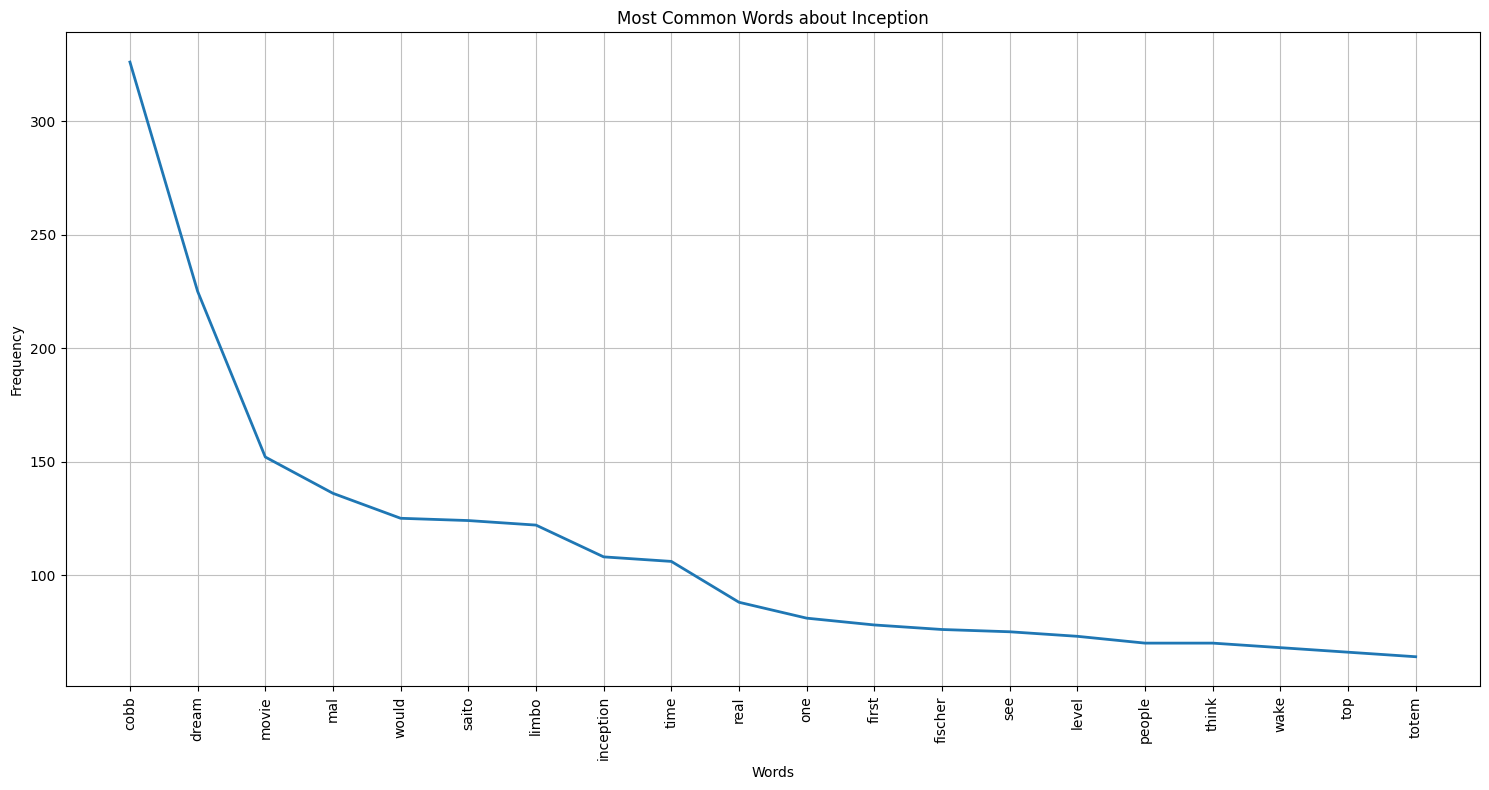

<Figure size 640x480 with 0 Axes>

In [31]:
#line plot
fig, ax = plt.subplots(1,1, figsize=(15,8)) 
ax = fdist.plot(25, title="Most Common Words about Inception")
ax.set_xlabel("Words")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.savefig('images/inceptionfrequency.jpg')

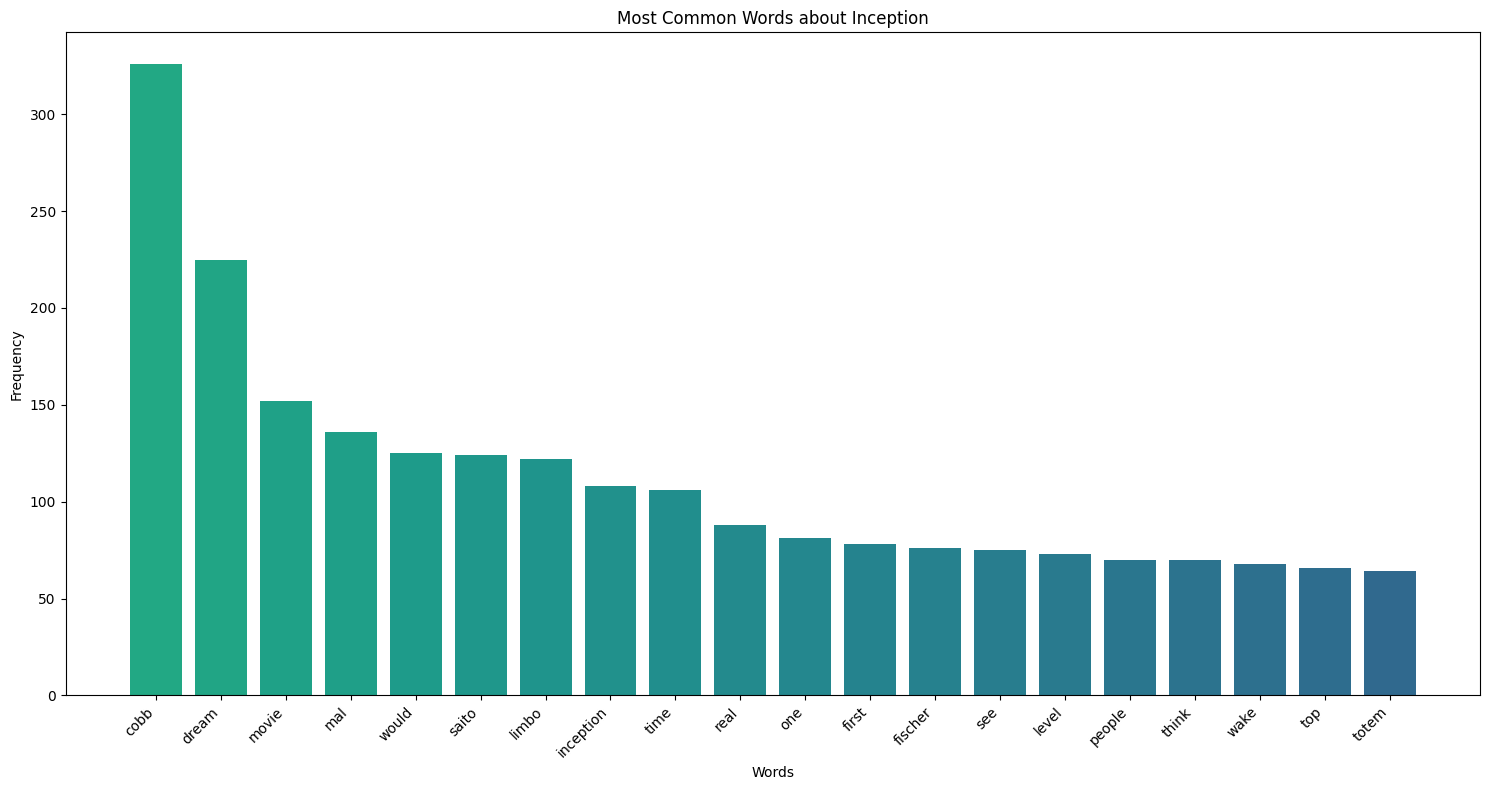

<Figure size 640x480 with 0 Axes>

In [41]:
# Split words and counts for plotting
words, counts = zip(*top_words)

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(words, counts, color=cm.viridis_r(np.linspace(.4,.8, 30)))
ax.set_title("Most Common Words about Inception")
ax.set_xlabel("Words")
ax.set_ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# plt.savefig('images/barInceptionFrequency.png')

In [65]:
# Let's assume your DataFrame is named df and 'split_review' is already a list of words
# Flatten all lists from the split_review column
all_words = [word for sublist in inception['split_review'] for word in sublist]

# Convert stopwords to a set for faster lookup
stop_words = set(stopwords.words('english'))

# Remove stopwords and lowercase the words
filtered_words = [word.lower() for word in all_words if word.lower() not in stop_words]
filtered_words[:7]
# # Create frequency distribution
# fdist = FreqDist(filtered_words)

# # Now you can inspect fdist
# print(fdist.most_common(20))  # Top 10 most frequent words

['hello', 'everyone!', 'exciting', 'news', 'fine', 'arts', 'theater']

In [63]:
# Step 1: Flatten the split_review column into one list of words with a DataFrame
words_df = inception['split_review'].explode().to_frame(name='word')

# Step 2: Lowercase words and filter out stopwords using `isin`
stop_words = set(stopwords.words('english'))
words_df['word'] = words_df['word'].str.lower()
filtered_df = words_df[~words_df['word'].isin(stop_words)]

# Step 3: Get word frequency using value_counts
fdist = filtered_df['word'].value_counts()

# Optional: Convert to dictionary or inspect top words
print(fdist.head(10))

word
cobb     346
dream    241
mal      153
movie    151
would    129
saito    126
limbo    125
know     125
like     116
time     110
Name: count, dtype: int64


In [64]:
# inception_words = inception['split_review'].explode().reset_index(drop=True)
# inception['split_review'].explode().reset_index()
# pd.DataFrame(inception['split_review'].explode())
# words_df.head()
# pd.DataFrame(inception['split_review'].explode().rename(columns={'split_review':'word'})

In [33]:
#freqDist - frequency of words within a text, in this case tweets about Inception
# fdist = FreqDist(inception['split_review'][0])

In [65]:
# fdist.most_common(2)

In [33]:
#distribution of vader score
# fig, ax = plt.subplots(figsize=(15,7))
# ax = sns.distplot(inception['vader_score'], color = 'firebrick')
# plt.xlabel('Sentiment Score', fontsize=18)
# plt.ylabel('Tweets per Score', fontsize=18)
# plt.title('VADER Sentiment of Inception', fontsize=22)
# plt.tick_params(labelsize='large')

# plt.savefig('images/VADERinception.jpg')

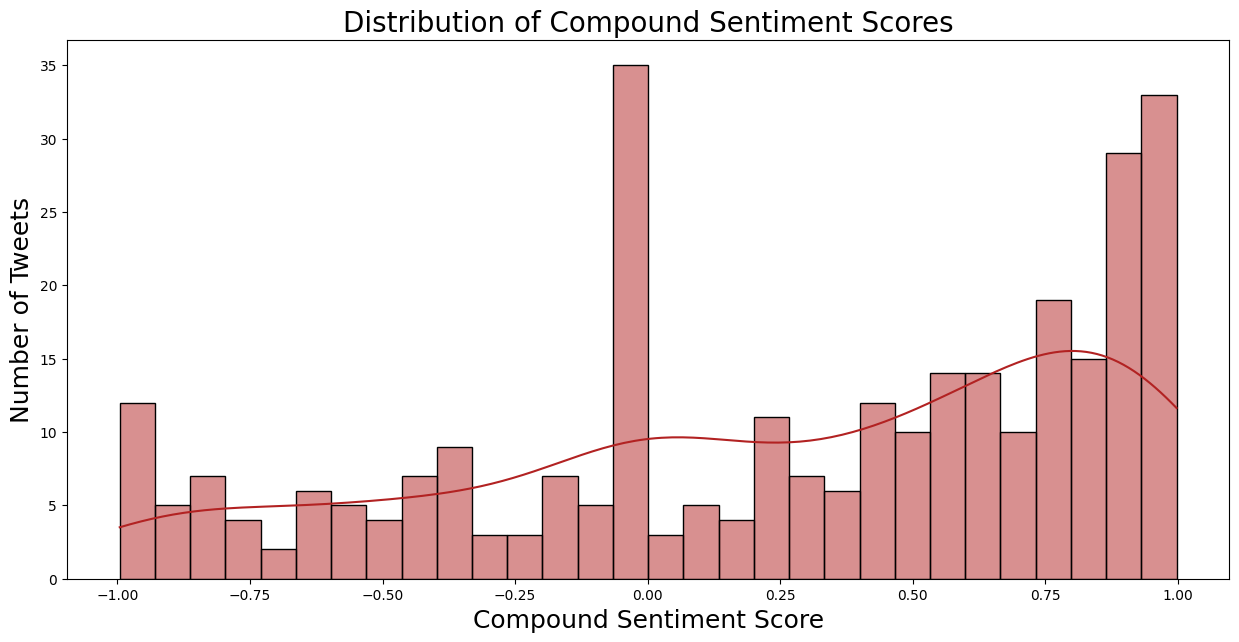

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\raize\\Dropbox\\Documents\\Data_Science\\Reddit_NLP_Sentiment\\Reddit_NLP_Sentiment\\images\\VADERinception.jpg'

<Figure size 640x480 with 0 Axes>

In [34]:
# Extract compound scores into a new column
inception['compound'] = inception['vader_score'].apply(lambda x: x['compound'] if isinstance(x, dict) else None)

# Plot the distribution
plt.figure(figsize=(15,7))
sns.histplot(inception['compound'].dropna(), color='firebrick', bins=30, kde=True)
plt.xlabel('Compound Sentiment Score', fontsize=18)
plt.ylabel('Number of Tweets', fontsize=18)
plt.title('Distribution of Compound Sentiment Scores', fontsize=20)
plt.show()

plt.savefig('Reddit_NLP_Sentiment/images/VADERinception.jpg')

In [35]:
inception.head(2)

,reviews,vader_score,positive sentiment score,negative sentiment score,neutral sentiment score,compound_score,sentiment,split_review,filtered_review,compound
0,Hello everyone! \n\nExciting news that The Fin...,"{'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'comp...",0.196,0.0,0.804,0.8879,Positive,"[hello, everyone!, exciting, news, that, the, ...","[hello, everyone!, exciting, news, fine, arts,...",0.8879
1,Dang I’m going away soon on summer holiday for...,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.091,0.0,0.909,0.4909,Positive,"[dang, i’m, going, away, soon, on, summer, hol...","[dang, i’m, going, away, soon, summer, holiday...",0.4909


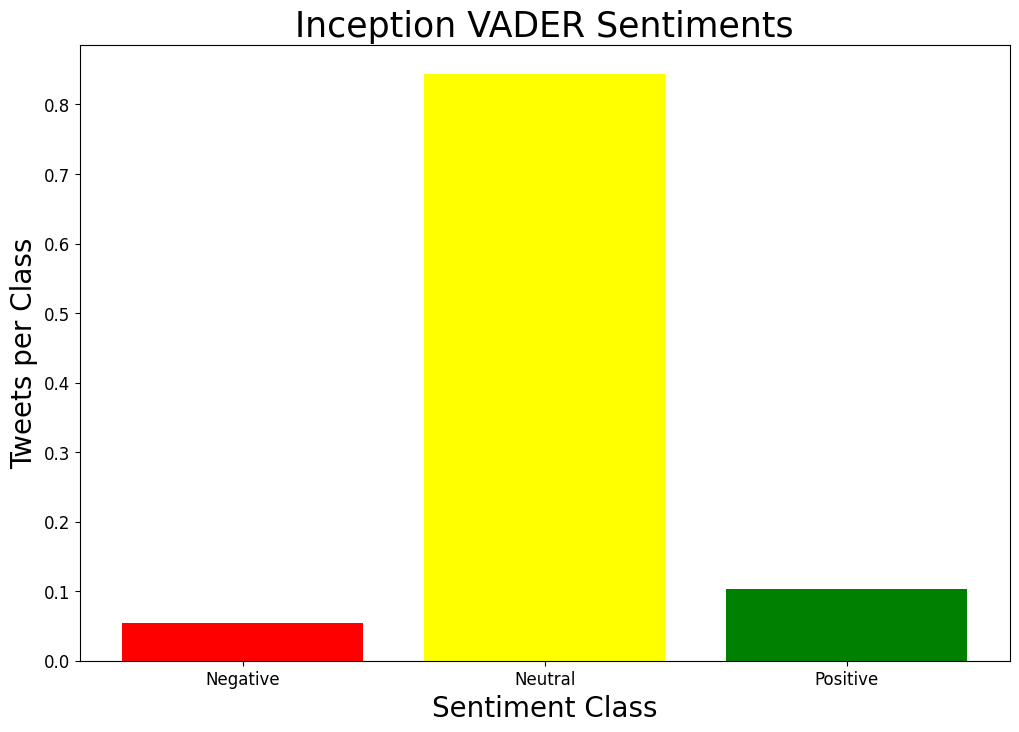

In [36]:
#bar plot representation of negative, neutral, and positive vader scores

avg_scores = {
    'Negative': inception['negative sentiment score'].mean(),
    'Neutral': inception['neutral sentiment score'].mean(),
    'Positive': inception['positive sentiment score'].mean()
}

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(avg_scores.keys(), avg_scores.values(), color =['red', 'yellow', 'green'])
plt.title('Inception VADER Sentiments', fontsize=25)
plt.xlabel('Sentiment Class', fontsize=20)
plt.ylabel('Tweets per Class', fontsize=20)
plt.tick_params(labelsize='large')

# plt.savefig('Reddit_NLP_Sentiment/images/inceptionsentiments.jpg')

## LDA & TSNE